# 7.9 BPTT (backpropagation through time)

## 7.9.1 モデルの定義

ライブラリの読み込み。

In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using Random
using ProgressMeter
using PyPlot

In [2]:
f(x) = tanh(x)
df(x) = 1 - tanh(x)^2

df (generic function with 1 method)

In [3]:
@kwdef struct RNNParameter{FT}
    dt::FT = 1 # time step (ms)
    τ::FT = 10 # time constant (ms)
    α::FT = dt / τ 
    η::FT = 1e-2 # learning rate
end

`w_in`は入力層から再帰層への重み、`w_rec`は再帰重み、`w_out`は出力重みである。

In [4]:
@kwdef mutable struct RNN{FT}
    param::RNNParameter = RNNParameter{FT}()
    
    n_batch::UInt32 # batch size
    n_in::UInt32 # number of input units
    n_rec::UInt32 # number of recurrent units
    n_out::UInt32 # number of output units
    
    h0::Array{FT} = zeros(n_batch, n_rec) # initial state of recurrent units

    # weights
    w_in::Array{FT} = 0.1*(rand(n_in, n_rec) .- 1)
    w_rec::Array{FT} = 1.5*randn(n_rec, n_rec)/sqrt(n_rec)
    w_out::Array{FT} = 0.1*(2*rand(n_rec, n_out) .- 1)/sqrt(n_rec)
    bias::Array{FT} = zeros(1, n_rec)
    
    # changes to weights
    dw_in::Array{FT} = zero(w_in)
    dw_rec::Array{FT} = zero(w_rec)
    dw_out::Array{FT} = zero(w_out)
    dbias::Array{FT} = zero(bias)
end

## 7.9.2 更新関数の定義

In [5]:
function update!(variable::RNN, param::RNNParameter, x::Array, y::Array, training::Bool)
    @unpack n_batch, n_in, n_rec, n_out, h0, w_in, w_rec, w_out, bias, dw_in, dw_rec, dw_out, dbias = variable 
    @unpack dt, τ, α, η = param

    t_max = size(x)[2]  # number of timesteps
    
    u = zeros(n_batch, t_max, n_rec) # input (feedforward + recurrent)
    h = zeros(n_batch, t_max, n_rec)  # time-dependent RNN activity vector
    h[:, 1, :] = h0  # initial state

    ŷ = zeros(n_batch, t_max, n_out)  # RNN output
    error = zeros(n_batch, t_max, n_out)  # readout error

    for t in 1:t_max-1
        u[:, t+1, :] = h[:, t, :] * w_rec + x[:, t+1, :] * w_in .+ bias
        h[:, t+1, :] = h[:, t, :] + α * (-h[:, t, :] + f.(u[:, t+1, :]))
        ŷ[:, t+1, :] = h[:, t+1, :] * w_out 
        error[:, t+1, :] = y[:, t+1, :] - ŷ[:, t+1, :]  # readout error
    end
    
    
    # backward
    if training 
        z = zero(h)
        z[:, end, :] = error[:, end, :] * w_out' 

        for t in t_max:-1:2
            zu = z[:, t, :] .* df.(u[:, t, :])
            z[:, t-1, :] = z[:, t, :] * (1 - α) + error[:, t, :] * w_out' + zu * w_rec * α

            # Updates  Δweights:
            dw_out[:, :] += h[:, t, :]' * error[:, t, :]
            dw_rec[:, :] += h[:, t-1, :]' * zu
            dw_in[:, :]  += x[:, t, :]' * zu
            dbias[:, :] .+= sum(zu)
        end
        
        # update weights
        w_out[:, :] += η/t_max * dw_out
        w_rec[:, :] += η/t_max * α * dw_rec
        w_in[:, :]  += η/t_max * α * dw_in
        bias[:, :]  += η/t_max * α * dbias
        
        # reset
        dw_in[:, :]  = zero(w_in)
        dw_rec[:, :] = zero(w_rec)
        dw_out[:, :] = zero(w_out)
        dbias[:, :]  = zero(bias)
    end

    return error, ŷ, h
end

update! (generic function with 1 method)

## 7.9.3 正弦波の学習
例として正弦波を出力するRNNを考える。入力1,中間64, 出力2のRNNである。

In [6]:
nt = 100  # number of timesteps in one period
n_batch = 1 # batch size
n_in = 1 # number of inputs
n_out = 2 # number of outputs

begin_input = 0 # begin time steps of input
end_input = 30  # end time steps of input

tsteps = 0:nt-1　# array of time steps
x = ones(n_batch) * (begin_input .≤ tsteps .≤ end_input)'  # input array

y = zeros(n_batch, nt, n_out) # target array
y[:, begin_input+1:end, 1] = sin.(tsteps[1:end-begin_input]*0.1)
y[:, begin_input+1:end, 2] = sin.(tsteps[1:end-begin_input]*0.2)

n_epoch = 25000 # number of epoch
error_arr = zeros(Float32, n_epoch) # memory array of each epoch error

25000-element Array{Float32,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

入力と訓練データの確認をする。

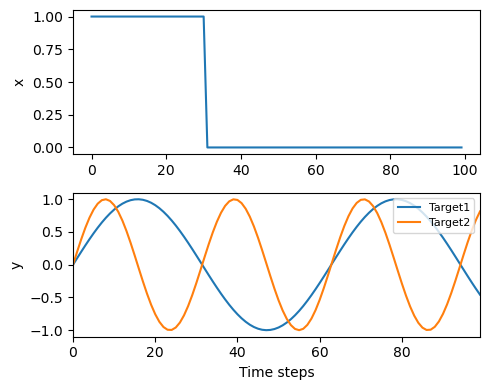

In [7]:
figure(figsize=(5, 4))
subplot(2,1,1)
plot(x[1, :])
ylabel("x")

subplot(2,1,2)
plot(tsteps, y[1, :, 1], label="Target1")
plot(tsteps, y[1, :, 2], label="Target2")
xlabel("Time steps"); ylabel("y"); xlim(0, tsteps[end])
legend(loc="upper right", fontsize=8)
tight_layout()

モデルの定義をする。

In [8]:
rnn = RNN{Float32}(n_batch=n_batch, n_in=n_in, n_rec=64, n_out=n_out)

RNN{Float32}(RNNParameter{Float32}(1.0f0, 10.0f0, 0.1f0, 0.01f0), 0x00000001, 0x00000001, 0x00000040, 0x00000002, Float32[0.0 0.0 … 0.0 0.0], Float32[-0.089150704 -0.0024821223 … -0.033192832 -0.06405964], Float32[0.007802181 -0.16197903 … -0.11315224 -0.05854143; 0.32444182 -0.13417901 … 0.24303919 -0.20546085; … ; -0.06686162 -0.031999115 … 0.16627055 -0.032601204; 0.12313597 -0.0013175466 … -0.09843764 -0.4011524], Float32[0.009122199 0.0008513517; 0.011272873 -0.011052974; … ; 0.0022174495 -0.0069803116; -0.005639966 0.007440812], Float32[0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0])

学習を実行する。

In [9]:
@showprogress "Training..." for e in 1:n_epoch
    error, ŷ, h = update!(rnn, rnn.param, x, y, true)
    error_arr[e] = sum(error .^ 2)
end

Training...100%|████████████████████████████████████████| Time: 0:03:01m9mmmmm


損失の推移を確認する。

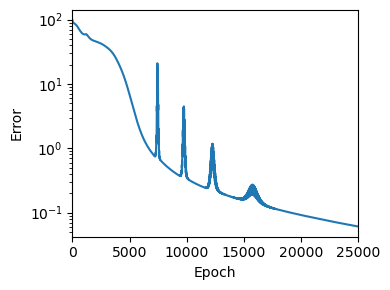

In [10]:
figure(figsize=(4,3))
semilogy(error_arr)
ylabel("Error"); xlabel("Epoch"); xlim(0, n_epoch)
tight_layout()

## 7.9.4 学習後の出力の確認

In [11]:
error, ŷ, h = update!(rnn, rnn.param, x, y, false)
println("Error : ", sum(error.^2))

Error : 0.06094371562786723


見やすいように出力のピークに応じて中間層のユニットをソートする。

In [12]:
max_idx = Tuple.(argmax(h[1, :, :]', dims=2))
h_ = h[1, :, sortperm(last.(max_idx)[:, 1])]

100×64 Array{Float64,2}:
  0.0         0.0         0.0        …   0.0        0.0         0.0
 -0.0527449  -0.0454744  -0.0538903     -0.059058  -0.0476463  -0.0596375
 -0.104116   -0.0898819  -0.0980861     -0.120017  -0.0824702  -0.112761
 -0.153529   -0.133236   -0.1347        -0.180682  -0.106422   -0.160729
 -0.200608   -0.175415   -0.165708      -0.23971   -0.121355   -0.204719
 -0.245121   -0.216228   -0.192885   …  -0.296314  -0.128956   -0.245704
 -0.28694    -0.255459   -0.217761      -0.35006   -0.130731   -0.284431
 -0.325996   -0.292887   -0.241592      -0.400737  -0.128007   -0.32144
 -0.362251   -0.328299   -0.265344      -0.44827   -0.121961   -0.357084
 -0.395673   -0.36149    -0.289698      -0.492665  -0.113639   -0.391557
 -0.42623    -0.392265   -0.315074   …  -0.533983  -0.103988   -0.424938
 -0.453872   -0.420435   -0.34166       -0.572318  -0.0938705  -0.45722
 -0.478531   -0.445818   -0.36945       -0.607786  -0.0840778  -0.48835
  ⋮                              

出力層、中間層の出力を描画する。

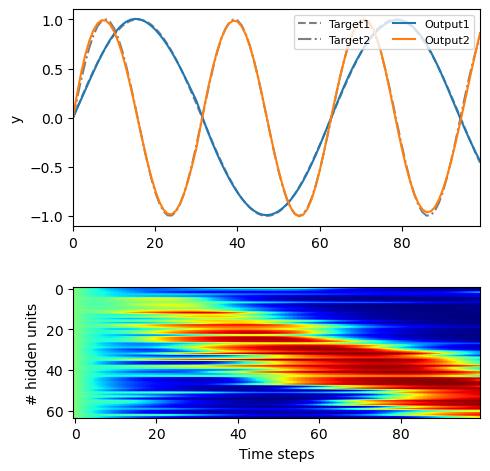

In [13]:
figure(figsize=(5, 5))
subplot(2,1,1)
plot(tsteps, y[1, :, 1], "--k", alpha=.5, label="Target1")
plot(tsteps, y[1, :, 2], "-.k", alpha=.5, label="Target2")
plot(tsteps, ŷ[1, :, 1], label="Output1")
plot(tsteps, ŷ[1, :, 2], label="Output2")
ylabel("y"); xlim(0, tsteps[end])
legend(loc="upper right", ncol=2, fontsize=8)

subplot(2,1,2)
imshow(h_', cmap="jet", aspect=0.5)
xlabel("Time steps"); ylabel("# hidden units")

tight_layout()